<h1>Training the MNIST:HAM10000 Skin Lesions Classification dataset</h1>

This notebook goes into more detail on how to actually train a CNN model, using the skin lesions classification case study example from Notebook 3. Before we jump straight into things, let's quickly make a summary of the steps we need to take: 

1. Importing the required libraries 

2. Preparing our data for training: 
    1. Downloading and understanding our dataset structure 
    2. Creating our training, validation, and testing custom <b>datasets</b> i.e., linking the images with their classes 
    3. Creating our training, validation, and testing <b>dataloaders</b> 

3. Designing our CNN model
4. Choosing our hyperparameters: training epochs, loss function, optimizer, learning rate

5. Passing our training and validation datasets through the model 
6. Visualizing the accuracy and loss of the training and validation process

7. And finally, passing our testing dataset through the trained and fine-tuned neural network 

<h3> Step 1: Importing the requried libraries </h3>

In [1]:
import torch
import torch.nn as nn 
import torch.nn.functional as F 
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import datasets, transforms
from torchvision.utils import make_grid
from PIL import Image

import torch_directml
dml = torch_directml.device()

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 

<h3>Step 2a: obtaining our dataset (downloaded from Kaggle) and understanding the structure</h3>

In [2]:
## From the Kaggle website, we are interested in two files/folders: 
    # MNIST HAM10000: contains the skin lesion images in the format of jpg files  
    # HAM10000_metadata.csv: contains the lesion_id, image_id, diagnosis (dx), etc.,  

## Processing the csv file 
folder_path = 'F:/Skin lesions classification/'
skin_cancer_csv = pd.read_csv(folder_path + 'HAM10000_metadata.csv')

## Printing the csv file structure
skin_cancer_csv

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear
...,...,...,...,...,...,...,...
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen
10013,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face


<h3>Step 2b: creating our custom dataset to assign the labels from the csv file to the jpg files</h3>

In [3]:
dx_labels = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
label_to_indices = {label: idx for idx, label in enumerate(dx_labels)}
label_indices = [label_to_indices[label] for label in dx_labels]

print(label_to_indices)
print(label_indices)

{'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}
[0, 1, 2, 3, 4, 5, 6]


In [4]:
# For this example, we have only downloaded half of the dataset (5000 images). Hence, we will only create our custom dataset from these:  
# (assigning the labels from the CSV file to the image files)
# for ease, we will sort the CSV into ascending order based on the image_id
sorted_df = skin_cancer_csv.sort_values(by=['image_id'])

## Creating our custom dataset using the PyTorch Dataset reference class: 
class CustomDataset(Dataset): 

    # Initialising the dataset with the required parameters 
    def __init__(self, root_dir, transform=None): 
        self.root_dir = root_dir
        self.transform = transform
        self.file_list = []

        # as all of our data is in the one MNIST:HAM10000 folder, we can simply append the image files to file_list
        # isolate the filenames and labels from the CSV file 
        file_names = sorted_df.iloc[:, 1]
        classes = sorted_df.iloc[:, 2]

        for sample in range(len(file_names)):
            sample_file = file_names.iloc[sample] + '.jpg'
            sample_class = classes.iloc[sample]
            sample_class = label_to_indices[sample_class]


            self.file_list.append((os.path.join(root_dir, sample_file), sample_class)) 

    # This method returns the number of samples in the dataset
    def __len__(self): 
        return len(self.file_list)
    
    # This method retrieves a sample and its corresponding label given an index. Used by the DataLoader internally to create batches during training 
    def __getitem__(self, idx): 
        image_path, class_name = self.file_list[idx]
        image = Image.open(image_path)

        if image.mode == 'L': 
            image = image.convert('RGB')
        
        if self.transform: 
            image = self.transform(image)

        class_name = torch.tensor(class_name, dtype=torch.long)
        return image, class_name



# Transformation to apply to the images (resizing, data augmentation)
transform = transforms.Compose([
    transforms.Resize((224, 224)), 
    transforms.ToTensor(),     
    transforms.RandomRotation(20), 
    transforms.RandomHorizontalFlip(), 
])
    

In [80]:
# Create the training, validation, and testing datasets 
full_dataset = CustomDataset(root_dir='F:/Skin lesions classification/MNIST HAM10000/', transform=transform)

# 80:20 split for training/valitation and testing 
len_training = int(0.8 * len(full_dataset)) 
len_test_data = len(full_dataset) - len_training

# 70:30 split of the 80% into training and validation
len_train_data = int(0.7 * len_training)
len_val_data = len_training - len_train_data

train_dataset, val_dataset, test_dataset = random_split(full_dataset, [len_train_data, len_val_data, len_test_data])


# Checking the size of the training, validation, and testing datasets
print(f'Training size: {len(train_dataset)} samples')
print(f'Validation: {len(val_dataset)} samples')
print(f'Testing: {len(test_dataset)} samples')

Training size: 5608 samples
Validation: 2404 samples
Testing: 2003 samples


<h3>Step 2c: creating and visualizing our DataLoader (a single batch)</h3>

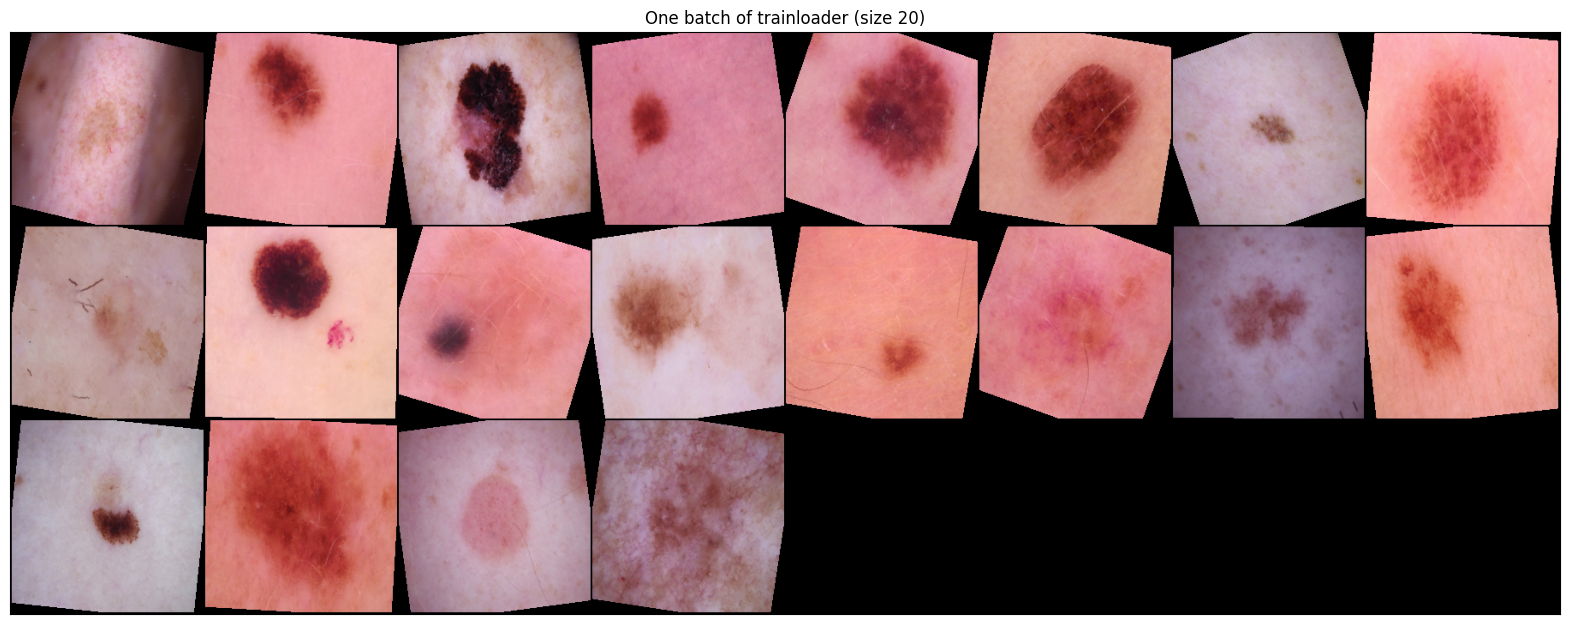

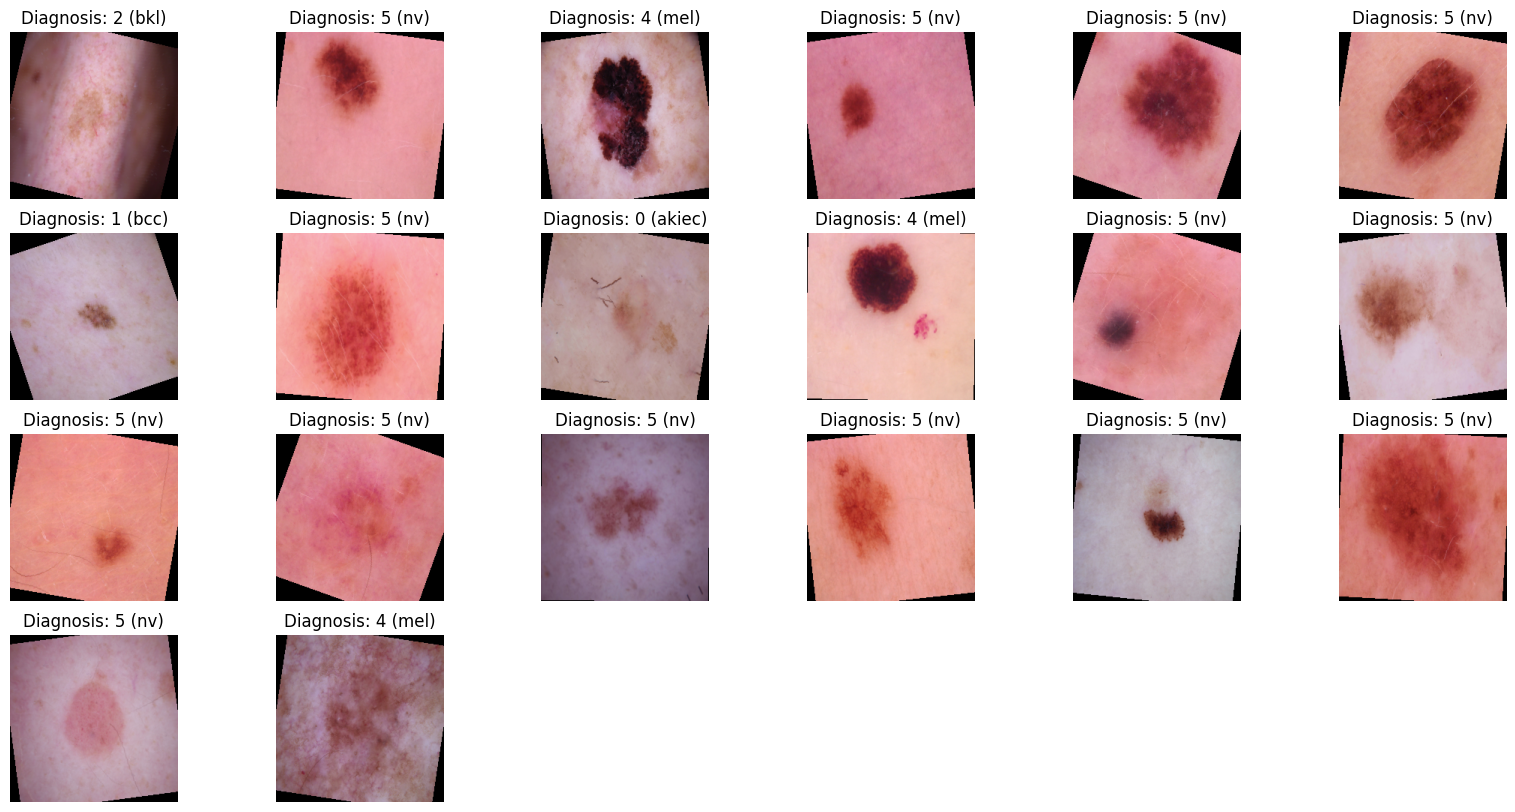

In [6]:
# Shuffle relevant datasets and use the torch dataloader
batch_size = 20

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Print a single instance of the dataloader for visualization  
images, labels = next(iter(train_loader))

fig1 = plt.figure(figsize=(20,10))
clean_grid = make_grid(images, normalize=True)

plt.imshow(clean_grid.numpy().transpose(1,2,0))
plt.tick_params(axis='x', bottom=False, labelbottom=False)
plt.tick_params(axis='y', left=False, labelleft=False)
plt.title(f'One batch of trainloader (size {batch_size})')



""" For visualisation purposes, let's see which labels are linked with each of the images 
    - akiec 
    - bcc
    - bkl
    - df
    - mel
    - nv
    - vasc
"""

# fig2, axs = plt.subplots(3, 8, figsize=(20,5))

# for i in range(batch_size): 
#     image = images[i]
#     image = (image.numpy().transpose(1,2,0))    # height x width x channels 
#     row = i//8; 
#     column = i%8; 
#     axs[row, column].imshow(image)
#     axs[row, column].set_title(f'Diagnosis: {labels[i]} ({dx_labels[labels[i]]})')
#     axs[row, column].axis('off')

plt.figure(figsize=(20,10))

for i in range(batch_size): 
    plt.subplot(4,6,i+1)

    image = images[i]
    image = (image.numpy().transpose(1,2,0))    # height x width x channels 
    
    plt.imshow(image)
    plt.title(f'Diagnosis: {labels[i]} ({dx_labels[labels[i]]})')
    plt.axis('off')


In [7]:
print(f'DataLoader dimensions: {images.shape}')

DataLoader dimensions: torch.Size([20, 3, 224, 224])


Notice that we converted the images sample from the DataLoader into a numpy array and transposed it. This is because by default, the tensor dimensions are: 
<center>[batch_size, number_of_channels, image_height, image_width] -> [24 x 3 x 224 x 224] </center>

To display the image properly, we need to rearrange the order into: 
<center>[batch_size, image_height, image_width, number_of channels] -> [24 x 224 x 224 x 3] </center>

Understanding the dimensions and order of dimensions is very important, which you will see later on when we actually design our neural network parameters

<h3>Step 3: Designing our CNN model</h3> 

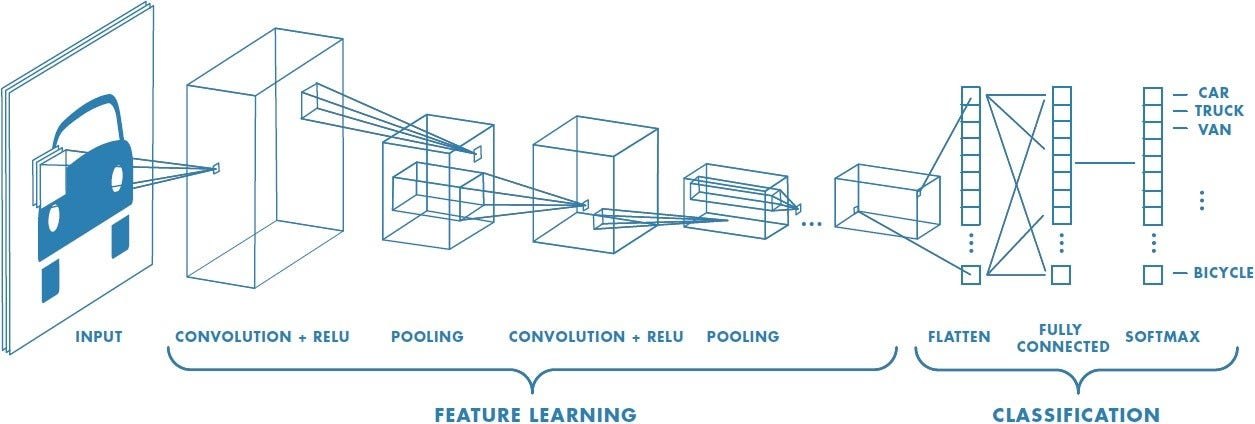

For simplicity, we will refer to the image above to design our neural network which contains sequential convolutional layers, ReLU activation functions, and pooling layers (repeated) before flattening into our 1D vector for classification. It is not shown in our diagram however, we also need to remember that we need activation functions in between our fully connected layers which is executed in the code below. 

Luckily, there is already a class structure from the torch.nn library called nn.Module that we can inherit and personalise for our own needs; however, there are two main methods that need to be changed: 
- <b>init</b>: what individual layers that our sample will pass through and the parameters that we want to choose
    - e.g., kernel size, stride, padding, the number of input and output channels
- <b>forward</b>: the order of the individual layers that our sample will pass through 

In [8]:
# Inheriting the nn.Module class to construct our custom neural network 
class MyCNN(nn.Module): 
    def __init__(self): 
        super(MyCNN, self).__init__()
        # Convolutional layers 
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)

        # Max pooling layer 
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)

        # Define fully connected layers 
        self.fc1 = nn.Linear(32 * 56 * 56, 256)
        self.fc2 = nn.Linear(256, 7)

        # # Batch normalization
        self.bn1 = nn.BatchNorm2d(16)
        self.bn2 = nn.BatchNorm2d(32)
        # self.bn3 = nn.BatchNorm1d(256)
        self.dropout = nn.Dropout(p=0.3)

    def forward(self, x): 
        # Convolutional layer 1
        # x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.conv1(x)))

        # Convolutional layer 2
        # x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.conv2(x)))

        # Flattening
        x = torch.flatten(x,1)
        # Fully connected layers 
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

# Making an instance of our model 
model = MyCNN()
model.to(dml)

MyCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (fc1): Linear(in_features=100352, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=7, bias=True)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

You are probably wondering how we obtained those values for each of the layers. There are a few things that we need to remember before we explain: 
- Our original dataloader had dimensions [24, 3, 224, 224], which means that we have 24 3-channel images that are 224 pixels in height and 224 pixels in width 
    -  i.e., 224x224 RGB images
- Generally, convolution is an operation where the convolved feature is smaller in dimensions than the input feature 
    - This is the case for the normal convolutional layers as well as the pooling layers 
    - Remember that we can resolve this by changing parameters such as padding and stride 

The following formula is useful when determining the dimensions of your convolved feature: 

$$ output_{width} = \lfloor \frac{W +2P - k}{S} + 1  \rfloor$$

$$ output_{height} = \lfloor \frac{H +2P - k}{S} + 1  \rfloor$$

where
- W and H represent the width and height of the input feature 
- P represents the padding 
- k represents the kernel size 
- S represents the stride in the particular dimension 
- These special brackets indicate that we need to perform floor rounding i.e., rounding down. We cannot round up to 6 if our output is 5.5 as we cannot simply 'create' more data 

Now, we will run through each of the layers and see whether our parameters are appropriate:
1. We start off with 224x224 3-channel RGB images 
2. Hence, the conv1 will expect an input_channel of 3. The number of output_channels 16 is arbitrary and may be changed, along with the kernel size, stride, and padding. Using the formula above, we notice that we have an output dimension of 224x224 which is the same as our input feature. This is because we specified a padding of 1 to preserve the spatial dimensions of these images; otherwise, they would have shrunk very early on. 
3. The 224x224 16-channel images are passed through the ReLU activation function which doesn't change the dimensions.
4. However, they are passed through our average pooling layer which halves the dimensions due to the kernel size and stride of 2. Now, we have 112x112 16-channel images.
5. Similarly, the conv2 will expect an input_channel of 16. The number of output_channels 32 is also arbitrary and with a similar kernel size and padding, we have an output dimension of 112x112 which is the same before passing through this convolutional layer. 
6. Again, nothing happens to the dimensions when we pass through our ReLU activation function.
7. As we are using the same average pooling layer, we once again halve our input dimensions. Hence, we go from 112x112 32-channel images to 56x56 32-channel images, which are then passed through our flattening and fully-connected layers. 
8. fc1 has an output size of 256 which is arbitrary and may be changed. 
9. fc2 accepts an input size of 256 (from fc1) and converts this to an output size of 7 as we have 7 classes of skin lesions.  

It is important that before you send your image into any of these layers, you need to make sure that the image is in a compatible format. For example, you will get unexpected results if you send in an 8-channel tensor when the first convolutional layer expects a 3-channel tensor. The significance of keeping track of your tensor dimensions is very apparent when you need to pass the image through your first fully-connected layer where we definitely need to know the dimensions of the input feature. 

<h3>Step 4: Choosing our hyperparameters for training</h3>

In [9]:
# Loss function 
loss_function = nn.CrossEntropyLoss()

# Learning rate
learning_rate = 0.001

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Number of training epochs 
epochs = 20


<h3>Step 5: Passing our training and validation datasets through the model</h3>

In [10]:
# keeping track of the accuracy and loss 
train_loss = []
train_accuracy = []
val_loss = []
val_accuracy = []

# Training for the specified number of epochs (cycles)
for epoch in range(epochs): 
    train_running_loss = 0.0
    train_correct = 0
    train_total = 0

    val_running_loss = 0.0
    val_correct = 0
    val_total = 0


    model.train()
    # Looping through each of the batches
    for i, data in enumerate(train_loader, 0): 
        train_images, train_classes = data[0].to(dml), data[1].to(dml)

        # Zero the parameter gradients (default: gradients are accumulated which is problematic between different batches)
        optimizer.zero_grad()

        # Forward pass -> feed the batch of images through our network 
        outputs = model(train_images)

        # Backpropagation -> calculate the loss by comparing the predicted outputs to the actual labels  
        loss = loss_function(outputs, train_classes)

        # Compute the gradients of the loss  
        loss.backward()

        # Optimization: updating the model's weights using the calculated gradients to minimize the loss 
        optimizer.step()

        # Updating running loss 
        train_running_loss += loss.item()

        # Calculating the accuracy 
        # The outputs are energies for the 7 classes => the higher the energy for a class, the more the network thinks that the image is of the particular class 
        # Hence, we will grab the index of the highest energy 
        _, predicted = torch.max(outputs.data, 1)
        train_total += train_classes.size(0)
        train_correct += (predicted == train_classes).sum().item()
    
    # Average loss and accuracy for each epoch 
    train_epoch_loss = train_running_loss / len(train_loader)
    train_epoch_accuracy = train_correct/train_total * 100

    print(f'Epoch {epoch+1}, Loss: {(train_epoch_loss):.3f}, Accuracy: {train_epoch_accuracy:.3f}%')

    # Append to our arrays 
    train_loss.append(train_epoch_loss)
    train_accuracy.append(train_epoch_accuracy)



    # Validation loop 
    model.eval()
    with torch.no_grad():
        for i, data in enumerate(val_loader): 
            val_images, val_classes = data[0].to(dml), data[1].to(dml)
            
            # Forward pass to generate a prediction
            outputs = model(val_images)

            # Calculating the loss -> no backproagation involved during validation
            loss = loss_function(outputs, val_classes)

            # Update running loss 
            val_running_loss += loss.item()

            # Calculating the accuracy 
            # The outputs are energies for the 7 classes => the higher the energy for a class, the more the network thinks that the image is of the particular class 
            # Hence, we will grab the index of the highest energy 
            _, predicted = torch.max(outputs.data, 1)
            val_total += val_classes.size(0)
            val_correct += (predicted == val_classes).sum().item()

    # Average loss and accuracy for each epoch 
    val_epoch_loss = val_running_loss / len(val_loader)
    val_epoch_accuracy = val_correct/val_total * 100

    print(f'Epoch {epoch+1}, Loss: {(val_epoch_loss):.3f}, Accuracy: {val_epoch_accuracy:.3f}%')

    # Append to our arrays 
    val_loss.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)


Epoch 1, Loss: 1.015, Accuracy: 65.835%
Epoch 1, Loss: 0.920, Accuracy: 67.596%
Epoch 2, Loss: 0.918, Accuracy: 67.564%
Epoch 2, Loss: 0.867, Accuracy: 69.343%
Epoch 3, Loss: 0.873, Accuracy: 68.545%
Epoch 3, Loss: 0.867, Accuracy: 69.176%
Epoch 4, Loss: 0.850, Accuracy: 68.830%
Epoch 4, Loss: 0.826, Accuracy: 69.925%
Epoch 5, Loss: 0.811, Accuracy: 69.597%
Epoch 5, Loss: 0.800, Accuracy: 70.008%
Epoch 6, Loss: 0.796, Accuracy: 70.542%
Epoch 6, Loss: 0.800, Accuracy: 70.923%
Epoch 7, Loss: 0.772, Accuracy: 70.489%
Epoch 7, Loss: 0.769, Accuracy: 71.339%
Epoch 8, Loss: 0.765, Accuracy: 71.273%
Epoch 8, Loss: 0.786, Accuracy: 71.256%
Epoch 9, Loss: 0.754, Accuracy: 71.933%
Epoch 9, Loss: 0.781, Accuracy: 71.339%
Epoch 10, Loss: 0.737, Accuracy: 72.254%
Epoch 10, Loss: 0.781, Accuracy: 71.880%
Epoch 11, Loss: 0.728, Accuracy: 72.165%
Epoch 11, Loss: 0.785, Accuracy: 72.047%
Epoch 12, Loss: 0.723, Accuracy: 72.325%
Epoch 12, Loss: 0.774, Accuracy: 70.300%
Epoch 13, Loss: 0.708, Accuracy: 7

<h3>Step 6: Visualising the accuracy and loss of the training and validation process</h3>

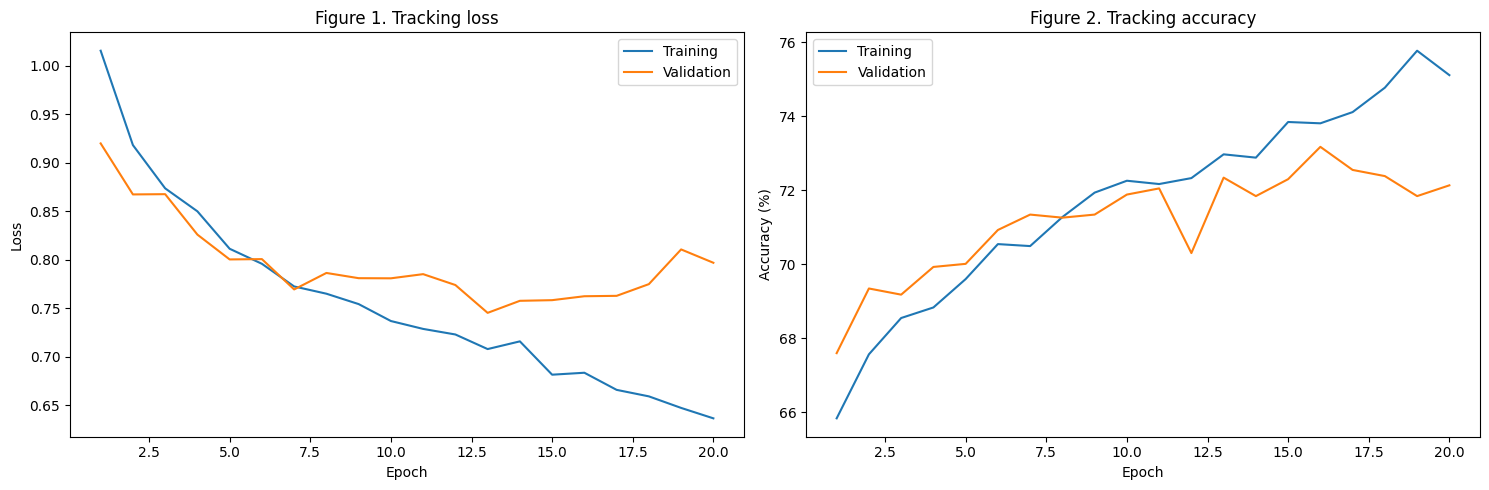

In [19]:
epoch_count = [i+1 for i in range(epochs)]

# Plotting the training loss
fig3, axs = plt.subplots(1, 2, figsize = (15,5))
axs[0].plot(epoch_count, train_loss, label='Training')
axs[0].plot(epoch_count, val_loss, label='Validation')
axs[0].set_title('Figure 1. Tracking loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()

axs[1].plot(epoch_count, train_accuracy, label='Training')
axs[1].plot(epoch_count, val_accuracy, label='Validation')
axs[1].set_title('Figure 2. Tracking accuracy')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy (%)')
axs[1].legend()

plt.tight_layout()
plt.show()

<h3>Step 7: Passing our testing dataset through the trained and fine-tuned neural network</h3>

In [52]:
# keeping track of the accuracy and loss 
test_loss = []
test_accuracy = []

correct = 0
total = 0

all_predictions = torch.tensor([]).to(dml)
all_truths = torch.tensor([]).to(dml)

# We do not need to calculate the gradients for our outputs when testing
with torch.no_grad():
    for i, data in enumerate(test_loader): 
        test_images, test_classes = data[0].to(dml), data[1].to(dml)
        outputs = model(test_images)

        # Calculating the accuracy 
        # The outputs are energies for the 7 classes => the higher the energy for a class, the more the network thinks that the image is of the particular class 
        # Hence, we will grab the index of the highest energy 
        _, predicted = torch.max(outputs.data, 1)
        total += test_classes.size(0)
        correct += (predicted == test_classes).sum().item()

        all_predictions = torch.cat((all_predictions, predicted), dim=0)
        all_truths = torch.cat((all_truths, test_classes))


print(f'Testing accuracy on {len(test_dataset)} images: {(correct / total * 100):.2f}%')

Testing accuracy on 2003 images: 72.64%


Great! We've trained our neural network, validated it on unseen data, and tried to pass through our testing dataset to see how well it predicts the skin lesion that a patient is diagnosed with. Before we analyse our performance, let's quickly remember why we need a training, validation, and testing split: 
- training dataset: used to fit/train the model i.e., determine the weights and biases of the neurons  
- validation dataset: unseen data that is used to fine-tune the model e.g., the learning rate, number of hidden units, etc 
- test dataset: a final evaluation of our trained model. Essentially, it is the 'final exam' (testing) that we all sit after we have been 'studying' (training) and 'revising' (validation)

Looking back at figures 1 and 2 that track both our training and validation losses and accuracies per epoch, we notice a couple of things. Firstly, both the training and validation losses decrease per epoch, which is what we are expecting from a neural network that should be improving at classification. In contrast, the accuracy is increasing per epoch however, this still means that our neural network is improving per epoch. 

In general, the validation loss is higher than the training loss (or the validation accuracy is lower than the training accuracy) which is expected as our model is constantly looking at the training data, potentially memorizing and updating its weights; whereas, the validation set is unseen data and notice that we do not actually perform any backpropagation in the validation loop. As a result, we get to a point where the model is not 'learning complex patterns' but instead, 'memorizing the images' (also known as overfitting) which is not ideal when it is presented with something completely unfamiliar that may be present in the test dataset. Theoretically, we want the training accuracy to increase per epoch, however, we also want the validation accuracy to not deviate too much from the training accuracy as this suggests the model is overfitting. In addition, the accuracies and losses for both the training and validation loops should be converging (stabilising/plateauing). This is not observed in the figures however, we may see more converging if we were to increase the number of training epochs. 

There are a few things we can do to overcome overfitting: 
- Regularization techniques such as batch normalization, L1/L2 regularization, dropout layers 
- Data augmentation to increase the size and variability of the training data e.g., rotations, colour changes, or resizing of the images

Overall, the training, validation, and testing accuracies are pretty low as well at around the low 70s, which may be improved by: 
- Building a deeper neural network by introducing more hidden layers and convolutional layers 
- Changing the hyperparameters e.g., learning rate, training epochs, optimizer choice (momentum)
- Transfer learning: instead of starting from scratch, we can use pre-trained models (trained on very large datasets) as a basis and fine-tune them to our specific task 

<b>Final note:</b> after looking deeper into the nature of the MNIST:HAM10000 dataset, we notice that the data is heavily biased towards the 'nv' diagnosis as there are over 6700 images for this diagnosis alone. Hence, the neural network has more opportunities to learn about the features for this diagnosis in comparison to the rest. This is reflected in the confusion matrix below where we see a bright yellow cell for the 'nv' diagnosis in comparison to the other cells. Head to the second last code cell where we show the distribution of the images for each dataset.   

<h3>Optional: Confusion matrix</h3>

In [27]:
# !pip install torchmetrics pytorch-lightning torchvision -qq

In [53]:
all_predictions = all_predictions.cpu()
all_truths = all_truths.cpu()

tensor([[   1,    7,   22,    1,    6,   30,    0],
        [   3,   22,   24,    1,    2,   39,    0],
        [   0,    2,   96,    0,    9,   97,    1],
        [   0,    3,    5,    0,    0,    5,    0],
        [   1,    2,   33,    0,   58,  140,    0],
        [   2,    8,   47,    0,   36, 1267,    0],
        [   0,    4,    0,    0,    1,   17,   11]])


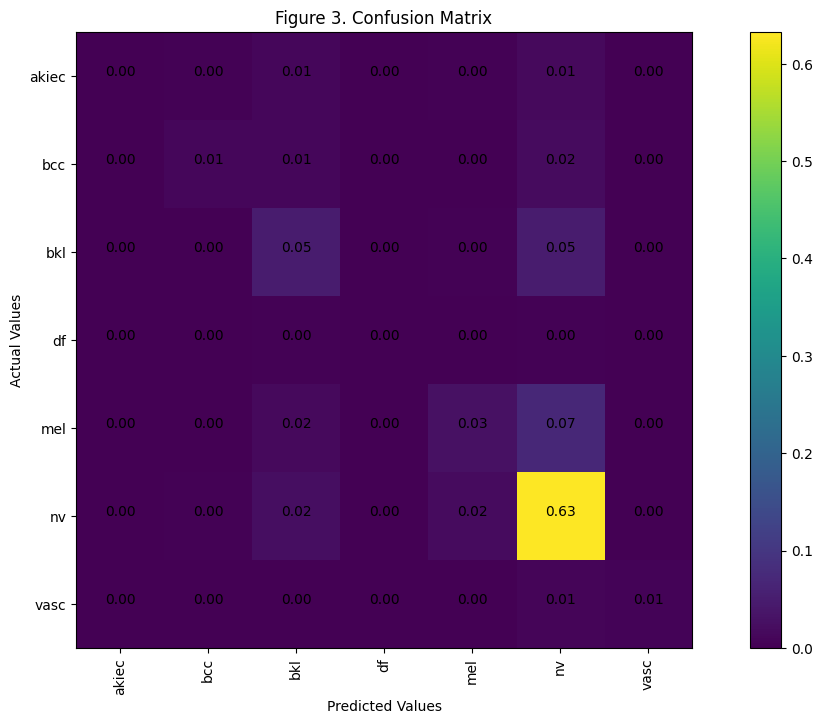

In [59]:
# FIRST ADDITIONAL ANALYSIS: Confusion Matrix 
from torchmetrics import ConfusionMatrix

# Create a ConfusionMatrix instance for multiclass classification with 'num_classes'
confusion_matrix_object = ConfusionMatrix(num_classes=len(dx_labels), task="multiclass")

# Compute the confusion matrix
confusion_matrix = confusion_matrix_object(all_predictions, all_truths)

# Print the confusion matrix
print(confusion_matrix)

# # standardise all the cells between 0 and 1
confusion_matrix = confusion_matrix / len(test_dataset)
confusion_matrix = confusion_matrix[0:len(dx_labels), 0:len(dx_labels)]

# Plot the confusion matrix
plt.figure(figsize=(15,8))
plt.imshow(confusion_matrix)
plt.title("Figure 3. Confusion Matrix")
plt.colorbar()

plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")

plt.xticks(np.arange(0, len(dx_labels)), dx_labels[0:(len(dx_labels))], rotation=90)
plt.yticks(np.arange(0, len(dx_labels)), dx_labels[0:(len(dx_labels))])

for i in range(len(dx_labels)): 
    for j in range(len(dx_labels)): 
        plt.text(j, i, f'{confusion_matrix[i, j]:.2f}', horizontalalignment="center")

In [82]:
## TROUBLESHOOTING Entire dataset 
count_array = np.array([0, 0, 0, 0, 0, 0, 0])
count_classes = sorted_df.iloc[:,2]

for i in range(len(count_classes)): 
    result = label_to_indices[count_classes[i]]
    count_array[result] += 1

print(np.vstack((np.array(dx_labels), count_array)))


[['akiec' 'bcc' 'bkl' 'df' 'mel' 'nv' 'vasc']
 ['327' '514' '1099' '115' '1113' '6705' '142']]


In [95]:
## TROUBLESHOOTING 
def image_dataset_assignment(dataset, dx_labels): 
    count_array = np.array([0, 0, 0, 0, 0, 0, 0])

    for i in range(len(dataset)): 
        value = dataset[i][1].item()
        count_array[value] += 1

    result = (np.vstack((np.array(dx_labels), count_array)))
    return result

print(f'Training set: \n{image_dataset_assignment(train_dataset, dx_labels)}\n')

print(f'Validation set: \n{image_dataset_assignment(val_dataset, dx_labels)}\n')

print(f'Testing set: \n{image_dataset_assignment(test_dataset, dx_labels)}\n')


Training set: 
[['akiec' 'bcc' 'bkl' 'df' 'mel' 'nv' 'vasc']
 ['189' '287' '610' '68' '642' '3735' '77']]

Validation set: 
[['akiec' 'bcc' 'bkl' 'df' 'mel' 'nv' 'vasc']
 ['69' '132' '263' '23' '268' '1612' '37']]

Testing set: 
[['akiec' 'bcc' 'bkl' 'df' 'mel' 'nv' 'vasc']
 ['69' '95' '226' '24' '203' '1358' '28']]



In [16]:
torch.save(model.state_dict(), folder_path + 'test1.pt')